# <font size="25" color="indianred">Data generation

# <font size="5" color="steelblue">Korteweg-de Vries (KdV) and Kuramoto Shivashinksy (KS) data generation

This notebook demonstrates the data generation for the Korteweg-de Vries and Kuramoto-Shivashinsky equation as used in the paper.

The **Korteweg-de Vries** equation reads 
$
- u_t = uu_x + u_{xxx} \ ,
$
where $uu_x$ is a non-linear convection term and $u_{xxx}$ a dispersive term. The nature of these terms requires careful attention for modeling. The **Kuramoto-Shivashinsky** equation is known for its chaotic behavior and reads
$
- u_t = uu_x + u_{xx} + u_{xxxx} \ .
$
Above being chaotic, it is nonlinear and the biharmonic term $u_{xxxx}$ is hard to model.


We solve these equations by using the methods of lines (MOL) in which all but the temporal dimension are discretized.Having the spatial derivatives numerically implemented results in a set of coupled ODEs for the time domain, which can be solved by using integration schemes of ODE solving.

Concretely, for getting numerical spatial derivatives, we use **pseudospectral methods**, where the derivatives are computed in the frequency domain by first applying a fast fourier transform (FFT) to the data, then multiplying by the appropriate values and converting back to the spatial domain with the inverse FFT. 

Mathematically this works since the Fourier transform of the $n$th derivative is given by:
$$
\displaystyle \widehat{f^{(n)}} (\xi) = \mathcal{F} \bigg( \frac{d^n}{dx^n} f(x) \bigg) = (2\pi i \xi)^n \widehat{f}(\xi) \ ,
$$
where $f(x)$ is an absolutely continuous differentiable function, and both $f$ and its derivative $f′$ are integrable. This method of differentiation in the Fourier space is implemented by the `diff` function in the module `scipy.fftpack`.
For integration in time we use an **implicit Runge-Kutta method** of Radau IIA family, order 5.

As a crosscheck, we use a **Finite Volume method** (FVM),
which is a valid approach since the equations at hand are in conservation form, i.e.
it can be shown via the divergence theorem that the integral of $u$ over cell $i$ increases only by the net flux into the cell. We therefore estimate the flux at the left and right cell boundary at time $t_k$, which we again do via the pseudospectral method of the module `scipy.fftpack`.



# <font size="5" color="steelblue">Imports

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff

# <font size="5" color="steelblue">Generate initial conditions
    
Initial conditions are sampled from a distribution over truncated Fourier series with random coefficients 
$\{A_k, \ell_k, \phi_k\}_k$ as
$$
    u_0(x) = \sum_{k=1}^N A_k \sin(2 \pi \ell_k x / L + \phi_k) \ .
$$

In [2]:
def generate_params() -> (int, np.ndarray, np.ndarray, np.ndarray):
    """
    Returns parameters for initial conditions.
    Args:
        None
    Returns:
        int: number of Fourier series terms
        np.ndarray: amplitude of different sine waves
        np.ndarray: phase shift of different sine waves
        np.ndarray: frequency of different sine waves
    """
    N = 10
    lmin, lmax = 1, 3
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0*np.pi*np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return (N, A, phi, l)

def initial_conditions(x: np.ndarray, L: int, params: Optional[list]=None) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    Args:
        x (np.ndarray): input array of spatial grid
        L (float): length of the spatial domain
        params (Optinal[list]): input parameters for generating initial conditions
    Returns:
        np.ndarray: initial condition
    """
    if params is None:
        params = generate_params()
    N, A, phi, l = params   
    u = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L ) + phi), -1)
    return u

# <font size="5" color="steelblue">Spatial derivatives for the Korteweg-de Vries equation

In [3]:
def kdv_pseudospectral(t: float, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for the KdV equation, using a pseudospectral method, descretization in x.
    Args:
        t (float): time point
        u (np.ndarray): 1D input field
        L (float): length of the spatial domain
    Returns:
        np.ndarray: reconstructed pseudospectral time derivative
    """
    # Compute the x derivatives using the pseudo-spectral method.
    ux = psdiff(u, order=1, period=L)
    uxxx = psdiff(u, order=3, period=L)
    # Compute du/dt.    
    dudt = -u*ux - uxxx
    return dudt

def kdv_fvm(t: float, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for the KdV equation, using a finite volume method, descretization in x.
    Args:
        t (float): time point
        u (np.ndarray): 1D input field
        L (float): length of the spatial domain
    Returns:
        np.ndarray: reconstructed pseudospectral time derivative
    """
    # Compute the x derivatives using the pseudo-spectral method.
    dx = L / len(u)  
    # Integrate: exact at half nodes
    u = u - np.sum(u)
    iu = np.cumsum(u) * dx
    # Derivatives
    u = psdiff(iu, order=0+1, period=L)
    uxx = psdiff(iu, order=2+1, period=L)
    # Compute du/dt.    
    Jrhs = 0.5 * (u**2) + uxx
    Jlhs = np.roll(Jrhs, 1)
    dudt = -(Jrhs - Jlhs) / dx
    return dudt

# <font size="5" color="steelblue">Solve for exemplary Korteweg-de Vries trajectory

In [4]:
# Set the size of the domain, and create the discretized grid.
L = 128
N = 2**7
x = np.linspace(0, (1-1.0/N)*L, N)
# Set the tolerance of the solver
tol = 1e-6

# Set the initial conditions.
u0 = initial_conditions(x, L)

# Set the time sample grid.
T = 100.
t = np.linspace(0, T, 200)

# Compute the solution using kdv_pseudospectral as spatial solver
sol_ps = solve_ivp(fun=kdv_pseudospectral, 
                               t_span=[t[0], t[-1]], 
                               y0=u0, 
                               method='Radau', 
                               t_eval=t, 
                               args=(L,), 
                               atol=tol, 
                               rtol=tol)
# Compute the solution using kdv_fvm as spatial solver
sol_fvm = solve_ivp(fun=kdv_fvm, 
                    t_span=[t[0], t[-1]], 
                    y0=u0, 
                    method='Radau', 
                    t_eval=t, 
                    args=(L, ), 
                    atol=tol, 
                    rtol=tol)   

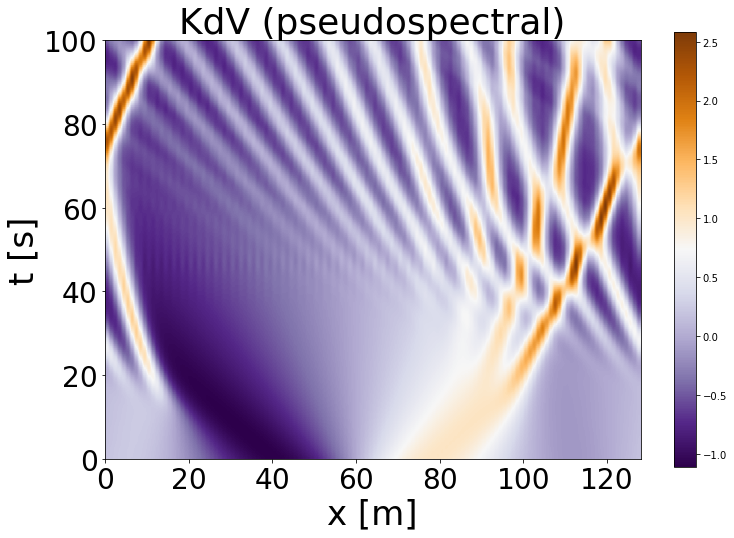

In [5]:
# Let's look at the trajectory obtained by using the pseudospectral spatial solver
if sol_ps.success:
    t_ps = sol_ps.y.T[::-1]
    plt.figure(figsize=(12,8))
    plt.imshow(t_ps, extent=[0,L,0,T], cmap='PuOr_r')
    plt.colorbar()
    plt.title('KdV (pseudospectral)', fontsize=36)
    plt.xlabel('x [m]', fontsize=34)
    plt.ylabel('t [s]', fontsize=34)
    plt.yticks(fontsize=28)
    plt.xticks(fontsize=28)
    plt.show()

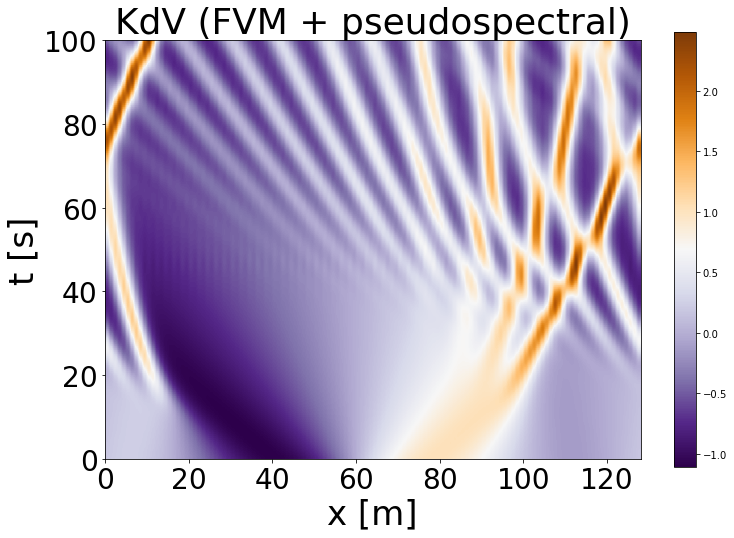

In [6]:
# Let's look at the trajectory obtained by using the pseudospectral spatial solver
if sol_fvm.success:
    t_fvm = sol_fvm.y.T[::-1]
    plt.figure(figsize=(12,8))
    plt.imshow(t_fvm, extent=[0,L,0,T], cmap='PuOr_r')
    plt.colorbar()
    plt.title('KdV (FVM + pseudospectral)', fontsize=36)
    plt.xlabel('x [m]', fontsize=34)
    plt.ylabel('t [s]', fontsize=34)
    plt.yticks(fontsize=28)
    plt.xticks(fontsize=28)
    plt.show()

# <font size="5" color="steelblue">Spatial derivatives for the Kuramoto-Shivashinsky equation

In [7]:
def ks_pseudospectral(t: float, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for the KS equation, using a pseudospectral method, descretization in x.
    Args:
        t (float): time point
        u (np.ndarray): 1D input field
        L (float): length of the spatial domain
    Returns:
        np.ndarray: reconstructed pseudospectral time derivative
    """
    # Compute the x derivatives using the pseudo-spectral method.
    ux = psdiff(u, period=L)
    uxx = psdiff(u, period=L, order=2)
    uxxxx = psdiff(u, period=L, order=4)
    # Compute du/dt.    
    dudt = - u*ux - uxx - uxxxx

    return dudt

def ks_fvm(t: float, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for the KS equation, using a finite volume method, descretization in x.
    Args:
        t (float): time point
        u (np.ndarray): 1D input field
        L (float): length of the spatial domain
    Returns:
        np.ndarray: reconstructed pseudospectral time derivative
    """
    # Compute the x derivatives using the pseudo-spectral method.
    dx = L / len(u)  
    # Integrate: exact at half nodes
    u = u - np.sum(u)
    iu = np.cumsum(u) * dx
    # Derivatives
    # Derivatives
    u = psdiff(iu, order=0+1, period=L)
    ux = psdiff(iu, order=1+1, period=L)
    uxxx = psdiff(iu, order=3+1, period=L)
    # Compute du/dt.    
    Jrhs = 0.5 * u**2 + ux + uxxx
    Jlhs = np.roll(Jrhs, 1)
    dudt = -(Jrhs - Jlhs) / dx
    return dudt

# <font size="5" color="steelblue">Solve for exemplary Kuramoto-Shivashinsky trajectory

In [8]:
# Set the size of the domain, and create the discretized grid.
L = 64
N = 2**7
x = np.linspace(0, (1-1.0/N)*L, N)
# Set the tolerance of the solver
tol = 1e-6

# Set the initial conditions.
u0 = initial_conditions(x, L)

# Set the time sample grid.
T = 100.
t = np.linspace(0, T, 200)

# Compute the solution using ks_pseudospectral as spatial solver
sol_ps = solve_ivp(fun=ks_pseudospectral, 
                               t_span=[t[0], t[-1]], 
                               y0=u0, 
                               method='Radau', 
                               t_eval=t, 
                               args=(L,), 
                               atol=tol, 
                               rtol=tol)
# Compute the solution using ks_fvm as spatial solver
sol_fvm = solve_ivp(fun=ks_fvm, 
                    t_span=[t[0], t[-1]], 
                    y0=u0, 
                    method='Radau', 
                    t_eval=t, 
                    args=(L, ), 
                    atol=tol, 
                    rtol=tol)

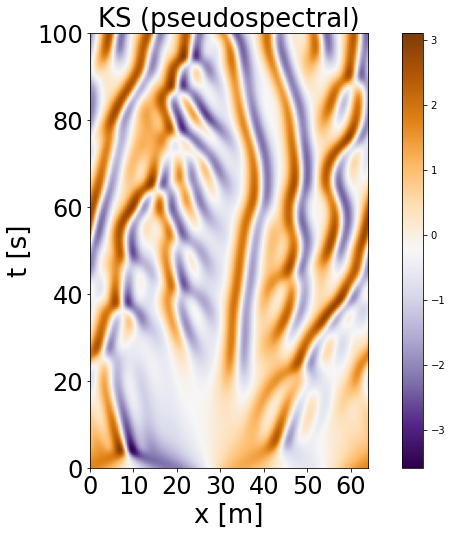

In [9]:
# Let's look at the trajectory obtained by using the pseudospectral spatial solver
if sol_ps.success:
    t_ps = sol_ps.y.T[::-1]
    plt.figure(figsize=(12,8))
    plt.imshow(t_ps, extent=[0,L,0,T], cmap='PuOr_r')
    plt.colorbar()
    plt.title('KS (pseudospectral)', fontsize=26)
    plt.xlabel('x [m]', fontsize=26)
    plt.ylabel('t [s]', fontsize=26)
    plt.yticks(fontsize=24)
    plt.xticks(fontsize=24)
    plt.show()

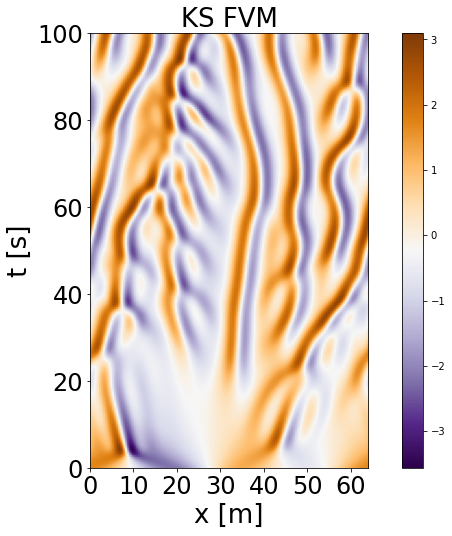

In [10]:
# Let's look at the trajectory obtained by using the pseudospectral spatial solver
if sol_fvm.success:
    t_fvm = sol_fvm.y.T[::-1]
    plt.figure(figsize=(12,8))
    plt.imshow(t_fvm, extent=[0,L,0,T], cmap='PuOr_r')
    plt.colorbar()
    plt.title('KS FVM', fontsize=26)
    plt.xlabel('x [m]', fontsize=26)
    plt.ylabel('t [s]', fontsize=26)
    plt.yticks(fontsize=24)
    plt.xticks(fontsize=24)
    plt.show()